# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

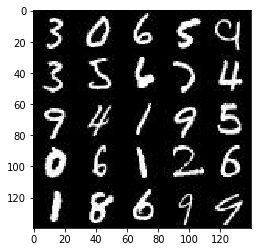

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

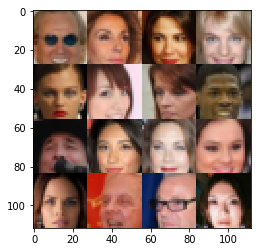

In [3]:
show_n_images = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_images = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_images')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, (None))

    return inputs_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
             
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 2, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 2, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [32]:
def generator(z, out_channel_dim, is_train=True, alpha=.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
  
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
    
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 4, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 4, strides=1, padding='same')
      
        
        out = tf.tanh(logits)
        
        return out

            
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim, alpha=.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [78]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, learn_r = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_r, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
              
                step = step+1
                                                        
                # scale to be between -1 and +1 
                X_std = (batch_images - np.amin(batch_images))/(np.amax(batch_images)-np.amin(batch_images))
                
                
                batch_images =  (X_std * 2) - 1
                
                
                 
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learn_r:learning_rate})
                # flip lables :
                
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,learn_r:learning_rate})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g), "  difference (D-G): {:.4f}".format(train_loss_d-train_loss_g) )

                if step % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

                    
               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 1.5434... Generator Loss: 0.4427   difference (D-G): 1.1007
Epoch 1/2 Step 20... Discriminator Loss: 1.1954... Generator Loss: 2.1484   difference (D-G): -0.9530
Epoch 1/2 Step 30... Discriminator Loss: 1.2957... Generator Loss: 1.2967   difference (D-G): -0.0010
Epoch 1/2 Step 40... Discriminator Loss: 1.5776... Generator Loss: 1.0080   difference (D-G): 0.5695
Epoch 1/2 Step 50... Discriminator Loss: 1.6606... Generator Loss: 1.2857   difference (D-G): 0.3749
Epoch 1/2 Step 60... Discriminator Loss: 1.4702... Generator Loss: 1.1684   difference (D-G): 0.3018
Epoch 1/2 Step 70... Discriminator Loss: 1.3789... Generator Loss: 0.8224   difference (D-G): 0.5564
Epoch 1/2 Step 80... Discriminator Loss: 1.3719... Generator Loss: 1.0586   difference (D-G): 0.3133
Epoch 1/2 Step 90... Discriminator Loss: 1.3246... Generator Loss: 0.8573   difference (D-G): 0.4672
Epoch 1/2 Step 100... Discriminator Loss: 1.2933... Generator Loss: 0.9381   difference (

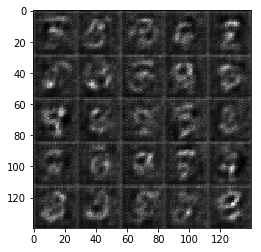

Epoch 1/2 Step 110... Discriminator Loss: 1.2845... Generator Loss: 0.9102   difference (D-G): 0.3742
Epoch 1/2 Step 120... Discriminator Loss: 1.3196... Generator Loss: 1.2840   difference (D-G): 0.0355
Epoch 1/2 Step 130... Discriminator Loss: 1.2063... Generator Loss: 1.0353   difference (D-G): 0.1709
Epoch 1/2 Step 140... Discriminator Loss: 1.3886... Generator Loss: 1.4388   difference (D-G): -0.0502
Epoch 1/2 Step 150... Discriminator Loss: 1.3400... Generator Loss: 0.5365   difference (D-G): 0.8036
Epoch 1/2 Step 160... Discriminator Loss: 1.2511... Generator Loss: 0.5934   difference (D-G): 0.6578
Epoch 1/2 Step 170... Discriminator Loss: 1.1419... Generator Loss: 1.6132   difference (D-G): -0.4713
Epoch 1/2 Step 180... Discriminator Loss: 1.1620... Generator Loss: 0.7949   difference (D-G): 0.3670
Epoch 1/2 Step 190... Discriminator Loss: 1.0488... Generator Loss: 1.0415   difference (D-G): 0.0074
Epoch 1/2 Step 200... Discriminator Loss: 1.3683... Generator Loss: 0.4869   dif

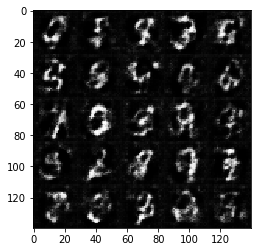

Epoch 1/2 Step 210... Discriminator Loss: 1.5463... Generator Loss: 0.3970   difference (D-G): 1.1493
Epoch 1/2 Step 220... Discriminator Loss: 1.6088... Generator Loss: 0.3794   difference (D-G): 1.2294
Epoch 1/2 Step 230... Discriminator Loss: 1.3728... Generator Loss: 0.5058   difference (D-G): 0.8671
Epoch 1/2 Step 240... Discriminator Loss: 1.1366... Generator Loss: 0.6924   difference (D-G): 0.4441
Epoch 1/2 Step 250... Discriminator Loss: 1.0798... Generator Loss: 0.7764   difference (D-G): 0.3034
Epoch 1/2 Step 260... Discriminator Loss: 1.4225... Generator Loss: 0.4566   difference (D-G): 0.9659
Epoch 1/2 Step 270... Discriminator Loss: 1.2438... Generator Loss: 0.6002   difference (D-G): 0.6436
Epoch 1/2 Step 280... Discriminator Loss: 1.0261... Generator Loss: 0.9224   difference (D-G): 0.1037
Epoch 1/2 Step 290... Discriminator Loss: 0.9359... Generator Loss: 1.2119   difference (D-G): -0.2760
Epoch 1/2 Step 300... Discriminator Loss: 1.1316... Generator Loss: 1.5776   diff

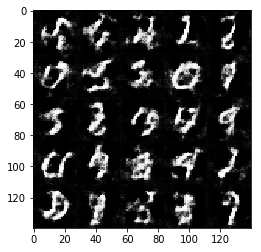

Epoch 1/2 Step 310... Discriminator Loss: 1.2891... Generator Loss: 0.5875   difference (D-G): 0.7016
Epoch 1/2 Step 320... Discriminator Loss: 1.6007... Generator Loss: 0.3684   difference (D-G): 1.2324
Epoch 1/2 Step 330... Discriminator Loss: 1.1133... Generator Loss: 0.9224   difference (D-G): 0.1910
Epoch 1/2 Step 340... Discriminator Loss: 1.3969... Generator Loss: 1.1130   difference (D-G): 0.2839
Epoch 1/2 Step 350... Discriminator Loss: 1.4045... Generator Loss: 1.4828   difference (D-G): -0.0783
Epoch 1/2 Step 360... Discriminator Loss: 1.3365... Generator Loss: 1.4550   difference (D-G): -0.1185
Epoch 1/2 Step 370... Discriminator Loss: 1.2130... Generator Loss: 0.9582   difference (D-G): 0.2547
Epoch 1/2 Step 380... Discriminator Loss: 1.3543... Generator Loss: 1.6062   difference (D-G): -0.2519
Epoch 1/2 Step 390... Discriminator Loss: 1.2184... Generator Loss: 1.0281   difference (D-G): 0.1903
Epoch 1/2 Step 400... Discriminator Loss: 1.2537... Generator Loss: 1.0097   di

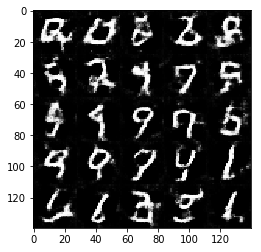

Epoch 1/2 Step 410... Discriminator Loss: 1.0886... Generator Loss: 1.2158   difference (D-G): -0.1272
Epoch 1/2 Step 420... Discriminator Loss: 1.2631... Generator Loss: 0.9210   difference (D-G): 0.3421
Epoch 1/2 Step 430... Discriminator Loss: 1.1507... Generator Loss: 0.8342   difference (D-G): 0.3164
Epoch 1/2 Step 440... Discriminator Loss: 1.2818... Generator Loss: 1.4769   difference (D-G): -0.1952
Epoch 1/2 Step 450... Discriminator Loss: 1.4164... Generator Loss: 0.4833   difference (D-G): 0.9331
Epoch 1/2 Step 460... Discriminator Loss: 1.3540... Generator Loss: 0.5083   difference (D-G): 0.8457
Epoch 1/2 Step 470... Discriminator Loss: 1.4390... Generator Loss: 0.4774   difference (D-G): 0.9616
Epoch 1/2 Step 480... Discriminator Loss: 1.0563... Generator Loss: 1.1485   difference (D-G): -0.0922
Epoch 1/2 Step 490... Discriminator Loss: 1.2095... Generator Loss: 0.8871   difference (D-G): 0.3224
Epoch 1/2 Step 500... Discriminator Loss: 1.2224... Generator Loss: 0.8158   di

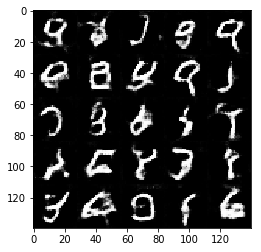

Epoch 1/2 Step 510... Discriminator Loss: 1.5533... Generator Loss: 0.3903   difference (D-G): 1.1630
Epoch 1/2 Step 520... Discriminator Loss: 1.4844... Generator Loss: 0.4238   difference (D-G): 1.0606
Epoch 1/2 Step 530... Discriminator Loss: 1.1043... Generator Loss: 1.4164   difference (D-G): -0.3121
Epoch 1/2 Step 540... Discriminator Loss: 1.3149... Generator Loss: 0.6838   difference (D-G): 0.6311
Epoch 1/2 Step 550... Discriminator Loss: 1.6804... Generator Loss: 0.3441   difference (D-G): 1.3363
Epoch 1/2 Step 560... Discriminator Loss: 1.4046... Generator Loss: 0.4825   difference (D-G): 0.9222
Epoch 1/2 Step 570... Discriminator Loss: 1.3837... Generator Loss: 0.5088   difference (D-G): 0.8749
Epoch 1/2 Step 580... Discriminator Loss: 1.1394... Generator Loss: 1.1573   difference (D-G): -0.0180
Epoch 1/2 Step 590... Discriminator Loss: 1.2324... Generator Loss: 1.3742   difference (D-G): -0.1418
Epoch 1/2 Step 600... Discriminator Loss: 1.0893... Generator Loss: 1.0283   di

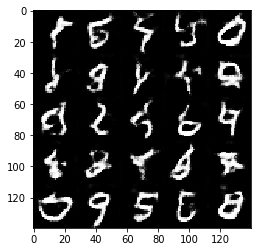

Epoch 1/2 Step 610... Discriminator Loss: 1.6746... Generator Loss: 0.3307   difference (D-G): 1.3438
Epoch 1/2 Step 620... Discriminator Loss: 1.4620... Generator Loss: 0.4599   difference (D-G): 1.0021
Epoch 1/2 Step 630... Discriminator Loss: 1.0876... Generator Loss: 0.7883   difference (D-G): 0.2992
Epoch 1/2 Step 640... Discriminator Loss: 1.0990... Generator Loss: 0.8753   difference (D-G): 0.2236
Epoch 1/2 Step 650... Discriminator Loss: 2.6140... Generator Loss: 2.9574   difference (D-G): -0.3434
Epoch 1/2 Step 660... Discriminator Loss: 1.1732... Generator Loss: 0.7776   difference (D-G): 0.3956
Epoch 1/2 Step 670... Discriminator Loss: 1.0917... Generator Loss: 0.7770   difference (D-G): 0.3148
Epoch 1/2 Step 680... Discriminator Loss: 1.0342... Generator Loss: 0.8954   difference (D-G): 0.1388
Epoch 1/2 Step 690... Discriminator Loss: 1.3166... Generator Loss: 0.5396   difference (D-G): 0.7770
Epoch 1/2 Step 700... Discriminator Loss: 0.9591... Generator Loss: 1.0915   diff

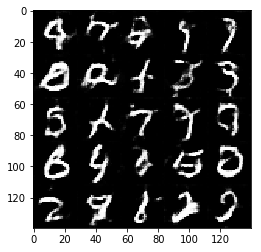

Epoch 1/2 Step 710... Discriminator Loss: 1.5850... Generator Loss: 0.3736   difference (D-G): 1.2114
Epoch 1/2 Step 720... Discriminator Loss: 1.3318... Generator Loss: 0.5458   difference (D-G): 0.7860
Epoch 1/2 Step 730... Discriminator Loss: 1.3077... Generator Loss: 0.5916   difference (D-G): 0.7161
Epoch 1/2 Step 740... Discriminator Loss: 1.1378... Generator Loss: 0.8615   difference (D-G): 0.2764
Epoch 1/2 Step 750... Discriminator Loss: 1.4349... Generator Loss: 1.7183   difference (D-G): -0.2834
Epoch 1/2 Step 760... Discriminator Loss: 1.1604... Generator Loss: 0.9615   difference (D-G): 0.1988
Epoch 1/2 Step 770... Discriminator Loss: 1.2354... Generator Loss: 0.6703   difference (D-G): 0.5650
Epoch 1/2 Step 780... Discriminator Loss: 1.1892... Generator Loss: 0.8384   difference (D-G): 0.3508
Epoch 1/2 Step 790... Discriminator Loss: 1.0064... Generator Loss: 1.2399   difference (D-G): -0.2335
Epoch 1/2 Step 800... Discriminator Loss: 1.0614... Generator Loss: 0.8222   dif

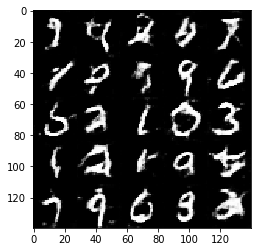

Epoch 1/2 Step 810... Discriminator Loss: 0.9430... Generator Loss: 1.4985   difference (D-G): -0.5554
Epoch 1/2 Step 820... Discriminator Loss: 1.3388... Generator Loss: 2.0938   difference (D-G): -0.7551
Epoch 1/2 Step 830... Discriminator Loss: 1.0581... Generator Loss: 0.9948   difference (D-G): 0.0633
Epoch 1/2 Step 840... Discriminator Loss: 1.1292... Generator Loss: 0.7861   difference (D-G): 0.3431
Epoch 1/2 Step 850... Discriminator Loss: 1.2389... Generator Loss: 0.5845   difference (D-G): 0.6544
Epoch 1/2 Step 860... Discriminator Loss: 0.9982... Generator Loss: 1.1784   difference (D-G): -0.1802
Epoch 1/2 Step 870... Discriminator Loss: 1.0292... Generator Loss: 0.9073   difference (D-G): 0.1219
Epoch 1/2 Step 880... Discriminator Loss: 0.8074... Generator Loss: 1.2644   difference (D-G): -0.4569
Epoch 1/2 Step 890... Discriminator Loss: 2.2226... Generator Loss: 0.2107   difference (D-G): 2.0118
Epoch 1/2 Step 900... Discriminator Loss: 1.4243... Generator Loss: 0.4748   d

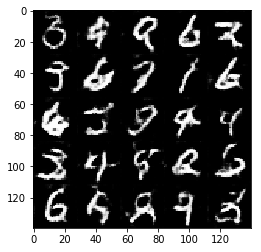

Epoch 1/2 Step 910... Discriminator Loss: 0.9240... Generator Loss: 0.9738   difference (D-G): -0.0498
Epoch 1/2 Step 920... Discriminator Loss: 1.0936... Generator Loss: 0.7902   difference (D-G): 0.3034
Epoch 1/2 Step 930... Discriminator Loss: 1.1487... Generator Loss: 0.7294   difference (D-G): 0.4192
Epoch 2/2 Step 940... Discriminator Loss: 1.7232... Generator Loss: 0.3164   difference (D-G): 1.4068
Epoch 2/2 Step 950... Discriminator Loss: 1.0686... Generator Loss: 1.0472   difference (D-G): 0.0214
Epoch 2/2 Step 960... Discriminator Loss: 1.1568... Generator Loss: 0.7364   difference (D-G): 0.4205
Epoch 2/2 Step 970... Discriminator Loss: 1.0144... Generator Loss: 0.8456   difference (D-G): 0.1688
Epoch 2/2 Step 980... Discriminator Loss: 1.2055... Generator Loss: 0.6552   difference (D-G): 0.5504
Epoch 2/2 Step 990... Discriminator Loss: 1.0052... Generator Loss: 1.2932   difference (D-G): -0.2881
Epoch 2/2 Step 1000... Discriminator Loss: 1.0942... Generator Loss: 1.9846   di

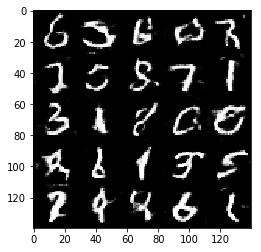

Epoch 2/2 Step 1010... Discriminator Loss: 1.0760... Generator Loss: 0.8334   difference (D-G): 0.2425
Epoch 2/2 Step 1020... Discriminator Loss: 0.9981... Generator Loss: 1.1450   difference (D-G): -0.1468
Epoch 2/2 Step 1030... Discriminator Loss: 1.1223... Generator Loss: 0.7821   difference (D-G): 0.3402
Epoch 2/2 Step 1040... Discriminator Loss: 1.3296... Generator Loss: 0.5429   difference (D-G): 0.7867
Epoch 2/2 Step 1050... Discriminator Loss: 2.8770... Generator Loss: 0.1145   difference (D-G): 2.7624
Epoch 2/2 Step 1060... Discriminator Loss: 1.0850... Generator Loss: 1.1300   difference (D-G): -0.0450
Epoch 2/2 Step 1070... Discriminator Loss: 1.1559... Generator Loss: 0.7781   difference (D-G): 0.3779
Epoch 2/2 Step 1080... Discriminator Loss: 0.9701... Generator Loss: 1.2353   difference (D-G): -0.2652
Epoch 2/2 Step 1090... Discriminator Loss: 1.2981... Generator Loss: 0.5620   difference (D-G): 0.7361
Epoch 2/2 Step 1100... Discriminator Loss: 0.9846... Generator Loss: 0

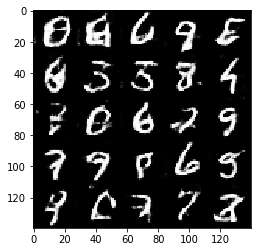

Epoch 2/2 Step 1110... Discriminator Loss: 1.9047... Generator Loss: 0.2845   difference (D-G): 1.6202
Epoch 2/2 Step 1120... Discriminator Loss: 1.2488... Generator Loss: 0.8286   difference (D-G): 0.4202
Epoch 2/2 Step 1130... Discriminator Loss: 1.1573... Generator Loss: 0.7300   difference (D-G): 0.4272
Epoch 2/2 Step 1140... Discriminator Loss: 0.9716... Generator Loss: 1.4268   difference (D-G): -0.4552
Epoch 2/2 Step 1150... Discriminator Loss: 0.9920... Generator Loss: 1.4310   difference (D-G): -0.4390
Epoch 2/2 Step 1160... Discriminator Loss: 0.9953... Generator Loss: 0.8842   difference (D-G): 0.1111
Epoch 2/2 Step 1170... Discriminator Loss: 1.2305... Generator Loss: 1.7902   difference (D-G): -0.5598
Epoch 2/2 Step 1180... Discriminator Loss: 1.1150... Generator Loss: 0.7440   difference (D-G): 0.3709
Epoch 2/2 Step 1190... Discriminator Loss: 1.1637... Generator Loss: 1.0102   difference (D-G): 0.1535
Epoch 2/2 Step 1200... Discriminator Loss: 1.0177... Generator Loss: 0

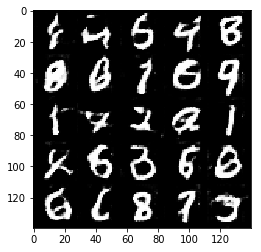

Epoch 2/2 Step 1210... Discriminator Loss: 1.2691... Generator Loss: 0.5548   difference (D-G): 0.7143
Epoch 2/2 Step 1220... Discriminator Loss: 1.1781... Generator Loss: 0.6528   difference (D-G): 0.5253
Epoch 2/2 Step 1230... Discriminator Loss: 0.9141... Generator Loss: 1.8460   difference (D-G): -0.9319
Epoch 2/2 Step 1240... Discriminator Loss: 1.2371... Generator Loss: 1.4013   difference (D-G): -0.1642
Epoch 2/2 Step 1250... Discriminator Loss: 1.8110... Generator Loss: 0.3034   difference (D-G): 1.5076
Epoch 2/2 Step 1260... Discriminator Loss: 1.2500... Generator Loss: 0.6489   difference (D-G): 0.6011
Epoch 2/2 Step 1270... Discriminator Loss: 1.1934... Generator Loss: 0.6585   difference (D-G): 0.5349
Epoch 2/2 Step 1280... Discriminator Loss: 1.2926... Generator Loss: 0.5336   difference (D-G): 0.7590
Epoch 2/2 Step 1290... Discriminator Loss: 1.2703... Generator Loss: 0.5457   difference (D-G): 0.7245
Epoch 2/2 Step 1300... Discriminator Loss: 0.9787... Generator Loss: 0.

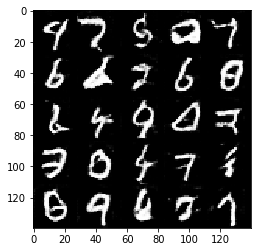

Epoch 2/2 Step 1310... Discriminator Loss: 0.7135... Generator Loss: 1.4148   difference (D-G): -0.7012
Epoch 2/2 Step 1320... Discriminator Loss: 0.9467... Generator Loss: 1.0901   difference (D-G): -0.1434
Epoch 2/2 Step 1330... Discriminator Loss: 0.9567... Generator Loss: 1.5168   difference (D-G): -0.5601
Epoch 2/2 Step 1340... Discriminator Loss: 0.9902... Generator Loss: 0.8857   difference (D-G): 0.1045
Epoch 2/2 Step 1350... Discriminator Loss: 1.0242... Generator Loss: 0.9034   difference (D-G): 0.1208
Epoch 2/2 Step 1360... Discriminator Loss: 1.2125... Generator Loss: 0.6280   difference (D-G): 0.5845
Epoch 2/2 Step 1370... Discriminator Loss: 0.9757... Generator Loss: 0.9399   difference (D-G): 0.0359
Epoch 2/2 Step 1380... Discriminator Loss: 1.7080... Generator Loss: 0.3511   difference (D-G): 1.3569
Epoch 2/2 Step 1390... Discriminator Loss: 1.3142... Generator Loss: 0.5659   difference (D-G): 0.7483
Epoch 2/2 Step 1400... Discriminator Loss: 1.2801... Generator Loss: 0

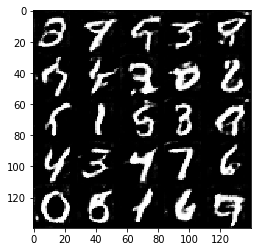

Epoch 2/2 Step 1410... Discriminator Loss: 0.9969... Generator Loss: 0.8910   difference (D-G): 0.1059
Epoch 2/2 Step 1420... Discriminator Loss: 1.3269... Generator Loss: 0.5878   difference (D-G): 0.7391
Epoch 2/2 Step 1430... Discriminator Loss: 0.9119... Generator Loss: 1.1628   difference (D-G): -0.2509
Epoch 2/2 Step 1440... Discriminator Loss: 1.7668... Generator Loss: 0.3304   difference (D-G): 1.4365
Epoch 2/2 Step 1450... Discriminator Loss: 1.4136... Generator Loss: 0.5081   difference (D-G): 0.9054
Epoch 2/2 Step 1460... Discriminator Loss: 0.9967... Generator Loss: 1.0147   difference (D-G): -0.0180
Epoch 2/2 Step 1470... Discriminator Loss: 1.0081... Generator Loss: 0.9044   difference (D-G): 0.1037
Epoch 2/2 Step 1480... Discriminator Loss: 1.1416... Generator Loss: 0.6735   difference (D-G): 0.4680
Epoch 2/2 Step 1490... Discriminator Loss: 1.1527... Generator Loss: 0.7438   difference (D-G): 0.4089
Epoch 2/2 Step 1500... Discriminator Loss: 1.0193... Generator Loss: 0.

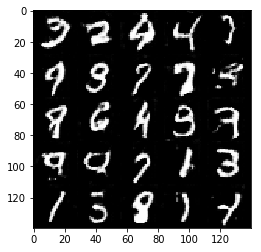

Epoch 2/2 Step 1510... Discriminator Loss: 0.6506... Generator Loss: 1.8658   difference (D-G): -1.2152
Epoch 2/2 Step 1520... Discriminator Loss: 0.9858... Generator Loss: 0.9354   difference (D-G): 0.0504
Epoch 2/2 Step 1530... Discriminator Loss: 2.1486... Generator Loss: 0.2004   difference (D-G): 1.9482
Epoch 2/2 Step 1540... Discriminator Loss: 1.5857... Generator Loss: 0.3841   difference (D-G): 1.2016
Epoch 2/2 Step 1550... Discriminator Loss: 1.1179... Generator Loss: 1.3423   difference (D-G): -0.2244
Epoch 2/2 Step 1560... Discriminator Loss: 1.3106... Generator Loss: 0.5630   difference (D-G): 0.7477
Epoch 2/2 Step 1570... Discriminator Loss: 0.9700... Generator Loss: 1.0734   difference (D-G): -0.1034
Epoch 2/2 Step 1580... Discriminator Loss: 1.3144... Generator Loss: 1.5840   difference (D-G): -0.2696
Epoch 2/2 Step 1590... Discriminator Loss: 1.1725... Generator Loss: 1.1996   difference (D-G): -0.0270
Epoch 2/2 Step 1600... Discriminator Loss: 0.8424... Generator Loss:

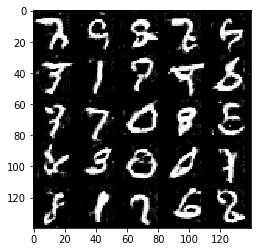

Epoch 2/2 Step 1610... Discriminator Loss: 0.8593... Generator Loss: 1.1849   difference (D-G): -0.3256
Epoch 2/2 Step 1620... Discriminator Loss: 1.2514... Generator Loss: 2.0546   difference (D-G): -0.8033
Epoch 2/2 Step 1630... Discriminator Loss: 1.5974... Generator Loss: 0.3812   difference (D-G): 1.2162
Epoch 2/2 Step 1640... Discriminator Loss: 0.9805... Generator Loss: 0.8740   difference (D-G): 0.1066
Epoch 2/2 Step 1650... Discriminator Loss: 0.9618... Generator Loss: 0.9530   difference (D-G): 0.0088
Epoch 2/2 Step 1660... Discriminator Loss: 1.1486... Generator Loss: 0.7005   difference (D-G): 0.4481
Epoch 2/2 Step 1670... Discriminator Loss: 1.4581... Generator Loss: 0.5073   difference (D-G): 0.9509
Epoch 2/2 Step 1680... Discriminator Loss: 1.0056... Generator Loss: 0.9338   difference (D-G): 0.0719
Epoch 2/2 Step 1690... Discriminator Loss: 2.2665... Generator Loss: 0.1856   difference (D-G): 2.0810
Epoch 2/2 Step 1700... Discriminator Loss: 1.5730... Generator Loss: 0.

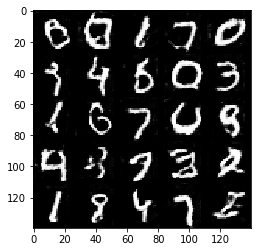

Epoch 2/2 Step 1710... Discriminator Loss: 0.9546... Generator Loss: 1.0419   difference (D-G): -0.0873
Epoch 2/2 Step 1720... Discriminator Loss: 1.0266... Generator Loss: 1.0157   difference (D-G): 0.0110
Epoch 2/2 Step 1730... Discriminator Loss: 0.7042... Generator Loss: 1.3363   difference (D-G): -0.6320
Epoch 2/2 Step 1740... Discriminator Loss: 2.2165... Generator Loss: 0.2029   difference (D-G): 2.0136
Epoch 2/2 Step 1750... Discriminator Loss: 0.9302... Generator Loss: 1.3935   difference (D-G): -0.4633
Epoch 2/2 Step 1760... Discriminator Loss: 1.1906... Generator Loss: 1.4943   difference (D-G): -0.3037
Epoch 2/2 Step 1770... Discriminator Loss: 1.5505... Generator Loss: 0.4072   difference (D-G): 1.1434
Epoch 2/2 Step 1780... Discriminator Loss: 0.9877... Generator Loss: 1.4907   difference (D-G): -0.5030
Epoch 2/2 Step 1790... Discriminator Loss: 1.3483... Generator Loss: 0.5266   difference (D-G): 0.8217
Epoch 2/2 Step 1800... Discriminator Loss: 1.8049... Generator Loss:

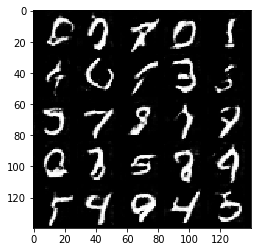

Epoch 2/2 Step 1810... Discriminator Loss: 1.2198... Generator Loss: 1.5131   difference (D-G): -0.2934
Epoch 2/2 Step 1820... Discriminator Loss: 0.9453... Generator Loss: 1.6493   difference (D-G): -0.7041
Epoch 2/2 Step 1830... Discriminator Loss: 0.9452... Generator Loss: 0.9421   difference (D-G): 0.0032
Epoch 2/2 Step 1840... Discriminator Loss: 1.1026... Generator Loss: 1.8999   difference (D-G): -0.7973
Epoch 2/2 Step 1850... Discriminator Loss: 1.0203... Generator Loss: 0.8053   difference (D-G): 0.2151
Epoch 2/2 Step 1860... Discriminator Loss: 1.1175... Generator Loss: 0.8188   difference (D-G): 0.2987
Epoch 2/2 Step 1870... Discriminator Loss: 1.1668... Generator Loss: 0.7768   difference (D-G): 0.3899


In [79]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... Discriminator Loss: 1.8354... Generator Loss: 0.3428   difference (D-G): 1.4926
Epoch 1/1 Step 20... Discriminator Loss: 1.3911... Generator Loss: 0.5459   difference (D-G): 0.8452
Epoch 1/1 Step 30... Discriminator Loss: 1.0273... Generator Loss: 0.8633   difference (D-G): 0.1640
Epoch 1/1 Step 40... Discriminator Loss: 0.9883... Generator Loss: 1.5651   difference (D-G): -0.5768
Epoch 1/1 Step 50... Discriminator Loss: 1.1990... Generator Loss: 0.7343   difference (D-G): 0.4648
Epoch 1/1 Step 60... Discriminator Loss: 1.1632... Generator Loss: 1.3356   difference (D-G): -0.1724
Epoch 1/1 Step 70... Discriminator Loss: 1.9850... Generator Loss: 0.2558   difference (D-G): 1.7293
Epoch 1/1 Step 80... Discriminator Loss: 1.5471... Generator Loss: 2.6381   difference (D-G): -1.0910
Epoch 1/1 Step 90... Discriminator Loss: 1.4544... Generator Loss: 0.5939   difference (D-G): 0.8605
Epoch 1/1 Step 100... Discriminator Loss: 1.4044... Generator Loss: 0.6012   difference 

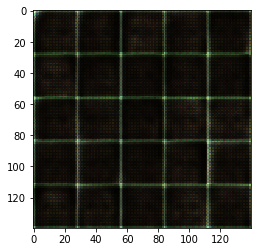

Epoch 1/1 Step 110... Discriminator Loss: 1.8046... Generator Loss: 0.3116   difference (D-G): 1.4930
Epoch 1/1 Step 120... Discriminator Loss: 1.4257... Generator Loss: 1.1451   difference (D-G): 0.2806
Epoch 1/1 Step 130... Discriminator Loss: 1.4323... Generator Loss: 0.7379   difference (D-G): 0.6944
Epoch 1/1 Step 140... Discriminator Loss: 1.6453... Generator Loss: 0.4782   difference (D-G): 1.1671
Epoch 1/1 Step 150... Discriminator Loss: 1.4544... Generator Loss: 0.5843   difference (D-G): 0.8701
Epoch 1/1 Step 160... Discriminator Loss: 1.2983... Generator Loss: 0.6189   difference (D-G): 0.6794
Epoch 1/1 Step 170... Discriminator Loss: 1.3626... Generator Loss: 0.7638   difference (D-G): 0.5988
Epoch 1/1 Step 180... Discriminator Loss: 1.2683... Generator Loss: 0.7311   difference (D-G): 0.5372
Epoch 1/1 Step 190... Discriminator Loss: 1.3790... Generator Loss: 0.6432   difference (D-G): 0.7357
Epoch 1/1 Step 200... Discriminator Loss: 1.2962... Generator Loss: 0.6756   diffe

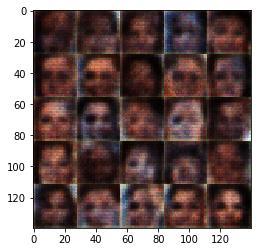

Epoch 1/1 Step 210... Discriminator Loss: 1.2887... Generator Loss: 0.7832   difference (D-G): 0.5055
Epoch 1/1 Step 220... Discriminator Loss: 0.9073... Generator Loss: 1.0778   difference (D-G): -0.1705
Epoch 1/1 Step 230... Discriminator Loss: 0.9735... Generator Loss: 1.7050   difference (D-G): -0.7315
Epoch 1/1 Step 240... Discriminator Loss: 1.2147... Generator Loss: 0.8821   difference (D-G): 0.3326
Epoch 1/1 Step 250... Discriminator Loss: 1.0583... Generator Loss: 0.9859   difference (D-G): 0.0723
Epoch 1/1 Step 260... Discriminator Loss: 0.8891... Generator Loss: 1.6176   difference (D-G): -0.7285
Epoch 1/1 Step 270... Discriminator Loss: 1.0218... Generator Loss: 1.1158   difference (D-G): -0.0940
Epoch 1/1 Step 280... Discriminator Loss: 1.1781... Generator Loss: 1.7138   difference (D-G): -0.5357
Epoch 1/1 Step 290... Discriminator Loss: 1.9492... Generator Loss: 0.3610   difference (D-G): 1.5882
Epoch 1/1 Step 300... Discriminator Loss: 1.6370... Generator Loss: 0.4168   

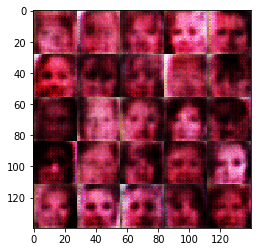

Epoch 1/1 Step 310... Discriminator Loss: 1.6504... Generator Loss: 0.5653   difference (D-G): 1.0851
Epoch 1/1 Step 320... Discriminator Loss: 1.6681... Generator Loss: 0.4475   difference (D-G): 1.2206
Epoch 1/1 Step 330... Discriminator Loss: 1.3220... Generator Loss: 0.9508   difference (D-G): 0.3711
Epoch 1/1 Step 340... Discriminator Loss: 1.4754... Generator Loss: 0.5551   difference (D-G): 0.9202
Epoch 1/1 Step 350... Discriminator Loss: 1.2689... Generator Loss: 0.8474   difference (D-G): 0.4215
Epoch 1/1 Step 360... Discriminator Loss: 1.3395... Generator Loss: 0.7381   difference (D-G): 0.6014
Epoch 1/1 Step 370... Discriminator Loss: 1.4633... Generator Loss: 0.5554   difference (D-G): 0.9078
Epoch 1/1 Step 380... Discriminator Loss: 1.4245... Generator Loss: 0.7293   difference (D-G): 0.6952
Epoch 1/1 Step 390... Discriminator Loss: 1.3535... Generator Loss: 0.9450   difference (D-G): 0.4084
Epoch 1/1 Step 400... Discriminator Loss: 1.2513... Generator Loss: 0.9722   diffe

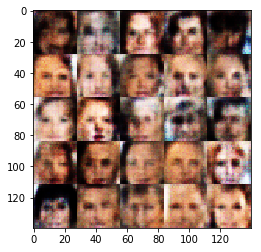

Epoch 1/1 Step 410... Discriminator Loss: 1.5232... Generator Loss: 0.6079   difference (D-G): 0.9153
Epoch 1/1 Step 420... Discriminator Loss: 1.3700... Generator Loss: 0.9087   difference (D-G): 0.4613
Epoch 1/1 Step 430... Discriminator Loss: 1.3540... Generator Loss: 0.8972   difference (D-G): 0.4568
Epoch 1/1 Step 440... Discriminator Loss: 1.3819... Generator Loss: 0.6872   difference (D-G): 0.6948
Epoch 1/1 Step 450... Discriminator Loss: 1.4341... Generator Loss: 0.8687   difference (D-G): 0.5653
Epoch 1/1 Step 460... Discriminator Loss: 1.3016... Generator Loss: 0.9118   difference (D-G): 0.3898
Epoch 1/1 Step 470... Discriminator Loss: 1.2739... Generator Loss: 0.7145   difference (D-G): 0.5594
Epoch 1/1 Step 480... Discriminator Loss: 1.2628... Generator Loss: 0.8390   difference (D-G): 0.4237
Epoch 1/1 Step 490... Discriminator Loss: 1.3152... Generator Loss: 0.8548   difference (D-G): 0.4604
Epoch 1/1 Step 500... Discriminator Loss: 1.3912... Generator Loss: 0.6115   diffe

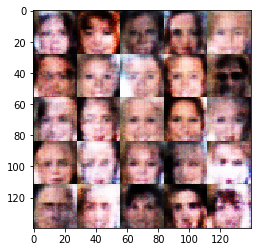

Epoch 1/1 Step 510... Discriminator Loss: 1.5724... Generator Loss: 0.5442   difference (D-G): 1.0282
Epoch 1/1 Step 520... Discriminator Loss: 1.4030... Generator Loss: 0.8425   difference (D-G): 0.5605
Epoch 1/1 Step 530... Discriminator Loss: 1.4605... Generator Loss: 0.5832   difference (D-G): 0.8772
Epoch 1/1 Step 540... Discriminator Loss: 1.4466... Generator Loss: 0.8767   difference (D-G): 0.5699
Epoch 1/1 Step 550... Discriminator Loss: 1.4794... Generator Loss: 0.9791   difference (D-G): 0.5003
Epoch 1/1 Step 560... Discriminator Loss: 1.2888... Generator Loss: 0.7163   difference (D-G): 0.5725
Epoch 1/1 Step 570... Discriminator Loss: 1.1780... Generator Loss: 0.7556   difference (D-G): 0.4224
Epoch 1/1 Step 580... Discriminator Loss: 1.3780... Generator Loss: 0.7340   difference (D-G): 0.6439
Epoch 1/1 Step 590... Discriminator Loss: 1.3808... Generator Loss: 0.9221   difference (D-G): 0.4587
Epoch 1/1 Step 600... Discriminator Loss: 1.3416... Generator Loss: 0.8878   diffe

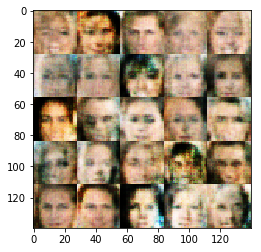

Epoch 1/1 Step 610... Discriminator Loss: 1.4066... Generator Loss: 0.6299   difference (D-G): 0.7767
Epoch 1/1 Step 620... Discriminator Loss: 1.2864... Generator Loss: 1.0104   difference (D-G): 0.2759
Epoch 1/1 Step 630... Discriminator Loss: 1.2790... Generator Loss: 1.0000   difference (D-G): 0.2790
Epoch 1/1 Step 640... Discriminator Loss: 1.2856... Generator Loss: 0.6791   difference (D-G): 0.6065
Epoch 1/1 Step 650... Discriminator Loss: 1.2398... Generator Loss: 0.8343   difference (D-G): 0.4056
Epoch 1/1 Step 660... Discriminator Loss: 1.2123... Generator Loss: 0.9524   difference (D-G): 0.2599
Epoch 1/1 Step 670... Discriminator Loss: 1.2605... Generator Loss: 0.9404   difference (D-G): 0.3201
Epoch 1/1 Step 680... Discriminator Loss: 1.2239... Generator Loss: 0.8764   difference (D-G): 0.3475
Epoch 1/1 Step 690... Discriminator Loss: 1.2214... Generator Loss: 1.1105   difference (D-G): 0.1110
Epoch 1/1 Step 700... Discriminator Loss: 1.1034... Generator Loss: 0.9741   diffe

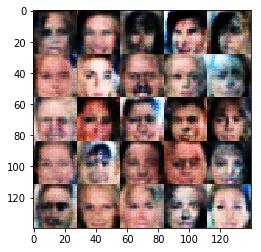

Epoch 1/1 Step 710... Discriminator Loss: 1.0881... Generator Loss: 1.0561   difference (D-G): 0.0320
Epoch 1/1 Step 720... Discriminator Loss: 1.5452... Generator Loss: 0.4308   difference (D-G): 1.1144
Epoch 1/1 Step 730... Discriminator Loss: 1.5959... Generator Loss: 0.4433   difference (D-G): 1.1526
Epoch 1/1 Step 740... Discriminator Loss: 1.2773... Generator Loss: 0.8796   difference (D-G): 0.3977
Epoch 1/1 Step 750... Discriminator Loss: 1.3177... Generator Loss: 1.0201   difference (D-G): 0.2976
Epoch 1/1 Step 760... Discriminator Loss: 1.1062... Generator Loss: 1.0194   difference (D-G): 0.0867
Epoch 1/1 Step 770... Discriminator Loss: 1.3915... Generator Loss: 0.6343   difference (D-G): 0.7572
Epoch 1/1 Step 780... Discriminator Loss: 1.3201... Generator Loss: 0.7135   difference (D-G): 0.6065
Epoch 1/1 Step 790... Discriminator Loss: 1.1566... Generator Loss: 0.9021   difference (D-G): 0.2545
Epoch 1/1 Step 800... Discriminator Loss: 1.2225... Generator Loss: 0.7573   diffe

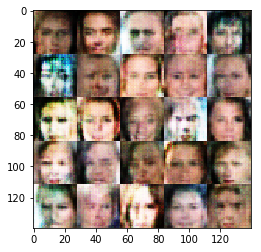

Epoch 1/1 Step 810... Discriminator Loss: 1.5477... Generator Loss: 0.5290   difference (D-G): 1.0187
Epoch 1/1 Step 820... Discriminator Loss: 1.2642... Generator Loss: 0.6852   difference (D-G): 0.5791
Epoch 1/1 Step 830... Discriminator Loss: 0.9837... Generator Loss: 1.0800   difference (D-G): -0.0963
Epoch 1/1 Step 840... Discriminator Loss: 1.2292... Generator Loss: 0.9448   difference (D-G): 0.2844
Epoch 1/1 Step 850... Discriminator Loss: 1.3856... Generator Loss: 0.6012   difference (D-G): 0.7844
Epoch 1/1 Step 860... Discriminator Loss: 1.1297... Generator Loss: 0.7459   difference (D-G): 0.3838
Epoch 1/1 Step 870... Discriminator Loss: 0.7661... Generator Loss: 1.6187   difference (D-G): -0.8525
Epoch 1/1 Step 880... Discriminator Loss: 1.0232... Generator Loss: 1.2978   difference (D-G): -0.2745
Epoch 1/1 Step 890... Discriminator Loss: 0.7707... Generator Loss: 1.2875   difference (D-G): -0.5167
Epoch 1/1 Step 900... Discriminator Loss: 1.2674... Generator Loss: 0.6444   d

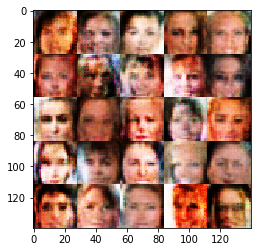

Epoch 1/1 Step 910... Discriminator Loss: 0.7869... Generator Loss: 1.8644   difference (D-G): -1.0775
Epoch 1/1 Step 920... Discriminator Loss: 0.8473... Generator Loss: 1.1198   difference (D-G): -0.2725
Epoch 1/1 Step 930... Discriminator Loss: 0.9689... Generator Loss: 1.1939   difference (D-G): -0.2250
Epoch 1/1 Step 940... Discriminator Loss: 0.9578... Generator Loss: 2.2569   difference (D-G): -1.2991
Epoch 1/1 Step 950... Discriminator Loss: 1.1057... Generator Loss: 1.9055   difference (D-G): -0.7997
Epoch 1/1 Step 960... Discriminator Loss: 1.3904... Generator Loss: 0.5251   difference (D-G): 0.8654
Epoch 1/1 Step 970... Discriminator Loss: 1.0049... Generator Loss: 0.8630   difference (D-G): 0.1418
Epoch 1/1 Step 980... Discriminator Loss: 1.5981... Generator Loss: 2.2675   difference (D-G): -0.6695
Epoch 1/1 Step 990... Discriminator Loss: 1.3067... Generator Loss: 0.6731   difference (D-G): 0.6336
Epoch 1/1 Step 1000... Discriminator Loss: 0.8164... Generator Loss: 1.2889 

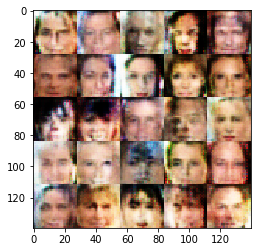

Epoch 1/1 Step 1010... Discriminator Loss: 1.2787... Generator Loss: 0.6455   difference (D-G): 0.6332
Epoch 1/1 Step 1020... Discriminator Loss: 1.5140... Generator Loss: 1.2303   difference (D-G): 0.2837
Epoch 1/1 Step 1030... Discriminator Loss: 1.0063... Generator Loss: 0.9258   difference (D-G): 0.0806
Epoch 1/1 Step 1040... Discriminator Loss: 1.5119... Generator Loss: 0.7475   difference (D-G): 0.7645
Epoch 1/1 Step 1050... Discriminator Loss: 0.6122... Generator Loss: 2.2227   difference (D-G): -1.6106
Epoch 1/1 Step 1060... Discriminator Loss: 1.2251... Generator Loss: 1.0455   difference (D-G): 0.1797
Epoch 1/1 Step 1070... Discriminator Loss: 1.4004... Generator Loss: 0.9046   difference (D-G): 0.4958
Epoch 1/1 Step 1080... Discriminator Loss: 1.1050... Generator Loss: 1.0394   difference (D-G): 0.0656
Epoch 1/1 Step 1090... Discriminator Loss: 0.9390... Generator Loss: 1.0572   difference (D-G): -0.1183
Epoch 1/1 Step 1100... Discriminator Loss: 0.9752... Generator Loss: 1.

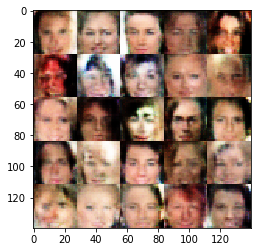

Epoch 1/1 Step 1110... Discriminator Loss: 1.5140... Generator Loss: 0.6179   difference (D-G): 0.8961
Epoch 1/1 Step 1120... Discriminator Loss: 0.9264... Generator Loss: 1.4481   difference (D-G): -0.5216
Epoch 1/1 Step 1130... Discriminator Loss: 0.8192... Generator Loss: 1.6717   difference (D-G): -0.8525
Epoch 1/1 Step 1140... Discriminator Loss: 0.6958... Generator Loss: 1.9697   difference (D-G): -1.2738
Epoch 1/1 Step 1150... Discriminator Loss: 0.9266... Generator Loss: 1.2068   difference (D-G): -0.2802
Epoch 1/1 Step 1160... Discriminator Loss: 1.1950... Generator Loss: 0.6957   difference (D-G): 0.4993
Epoch 1/1 Step 1170... Discriminator Loss: 0.9408... Generator Loss: 1.2650   difference (D-G): -0.3242
Epoch 1/1 Step 1180... Discriminator Loss: 1.4173... Generator Loss: 1.1484   difference (D-G): 0.2689
Epoch 1/1 Step 1190... Discriminator Loss: 0.8671... Generator Loss: 1.3140   difference (D-G): -0.4469
Epoch 1/1 Step 1200... Discriminator Loss: 0.9346... Generator Loss

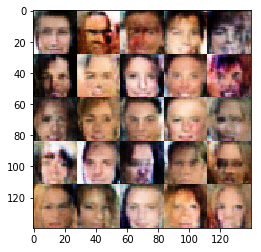

Epoch 1/1 Step 1210... Discriminator Loss: 0.8899... Generator Loss: 1.2059   difference (D-G): -0.3159
Epoch 1/1 Step 1220... Discriminator Loss: 2.2705... Generator Loss: 1.9272   difference (D-G): 0.3432
Epoch 1/1 Step 1230... Discriminator Loss: 0.9376... Generator Loss: 1.0143   difference (D-G): -0.0767
Epoch 1/1 Step 1240... Discriminator Loss: 1.4301... Generator Loss: 0.5198   difference (D-G): 0.9103
Epoch 1/1 Step 1250... Discriminator Loss: 0.9354... Generator Loss: 1.7828   difference (D-G): -0.8474
Epoch 1/1 Step 1260... Discriminator Loss: 0.7697... Generator Loss: 1.5650   difference (D-G): -0.7953
Epoch 1/1 Step 1270... Discriminator Loss: 0.6639... Generator Loss: 1.8991   difference (D-G): -1.2352
Epoch 1/1 Step 1280... Discriminator Loss: 1.6433... Generator Loss: 0.5405   difference (D-G): 1.1028
Epoch 1/1 Step 1290... Discriminator Loss: 1.4377... Generator Loss: 0.5616   difference (D-G): 0.8761
Epoch 1/1 Step 1300... Discriminator Loss: 1.0427... Generator Loss:

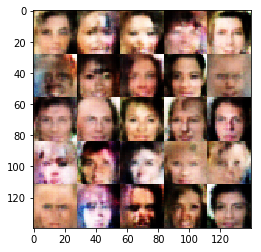

Epoch 1/1 Step 1310... Discriminator Loss: 0.6139... Generator Loss: 2.1439   difference (D-G): -1.5299
Epoch 1/1 Step 1320... Discriminator Loss: 0.8860... Generator Loss: 1.7449   difference (D-G): -0.8589
Epoch 1/1 Step 1330... Discriminator Loss: 1.0715... Generator Loss: 1.1238   difference (D-G): -0.0523
Epoch 1/1 Step 1340... Discriminator Loss: 1.8489... Generator Loss: 0.3365   difference (D-G): 1.5123
Epoch 1/1 Step 1350... Discriminator Loss: 1.6124... Generator Loss: 0.5750   difference (D-G): 1.0374
Epoch 1/1 Step 1360... Discriminator Loss: 1.2971... Generator Loss: 0.7094   difference (D-G): 0.5878
Epoch 1/1 Step 1370... Discriminator Loss: 1.4353... Generator Loss: 0.6063   difference (D-G): 0.8290
Epoch 1/1 Step 1380... Discriminator Loss: 1.2038... Generator Loss: 0.7447   difference (D-G): 0.4591
Epoch 1/1 Step 1390... Discriminator Loss: 1.0597... Generator Loss: 0.9038   difference (D-G): 0.1559
Epoch 1/1 Step 1400... Discriminator Loss: 1.5223... Generator Loss: 0

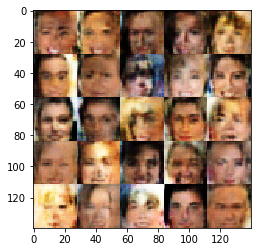

Epoch 1/1 Step 1410... Discriminator Loss: 1.3735... Generator Loss: 0.6043   difference (D-G): 0.7692
Epoch 1/1 Step 1420... Discriminator Loss: 1.2868... Generator Loss: 0.6047   difference (D-G): 0.6821
Epoch 1/1 Step 1430... Discriminator Loss: 0.8525... Generator Loss: 1.6557   difference (D-G): -0.8032
Epoch 1/1 Step 1440... Discriminator Loss: 1.4125... Generator Loss: 0.6181   difference (D-G): 0.7944
Epoch 1/1 Step 1450... Discriminator Loss: 0.8837... Generator Loss: 1.9620   difference (D-G): -1.0783
Epoch 1/1 Step 1460... Discriminator Loss: 1.0675... Generator Loss: 0.8221   difference (D-G): 0.2454
Epoch 1/1 Step 1470... Discriminator Loss: 0.7426... Generator Loss: 1.7277   difference (D-G): -0.9852
Epoch 1/1 Step 1480... Discriminator Loss: 0.8293... Generator Loss: 1.5773   difference (D-G): -0.7480
Epoch 1/1 Step 1490... Discriminator Loss: 0.8315... Generator Loss: 1.0428   difference (D-G): -0.2112
Epoch 1/1 Step 1500... Discriminator Loss: 0.8611... Generator Loss:

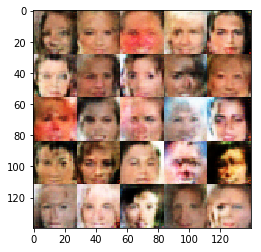

Epoch 1/1 Step 1510... Discriminator Loss: 1.1586... Generator Loss: 0.9955   difference (D-G): 0.1631
Epoch 1/1 Step 1520... Discriminator Loss: 1.3868... Generator Loss: 1.3767   difference (D-G): 0.0101
Epoch 1/1 Step 1530... Discriminator Loss: 1.1397... Generator Loss: 0.7439   difference (D-G): 0.3958
Epoch 1/1 Step 1540... Discriminator Loss: 1.1390... Generator Loss: 1.2113   difference (D-G): -0.0722
Epoch 1/1 Step 1550... Discriminator Loss: 0.8032... Generator Loss: 2.1149   difference (D-G): -1.3117
Epoch 1/1 Step 1560... Discriminator Loss: 1.2463... Generator Loss: 0.6508   difference (D-G): 0.5954
Epoch 1/1 Step 1570... Discriminator Loss: 1.2899... Generator Loss: 0.5860   difference (D-G): 0.7039
Epoch 1/1 Step 1580... Discriminator Loss: 0.8336... Generator Loss: 1.2619   difference (D-G): -0.4283
Epoch 1/1 Step 1590... Discriminator Loss: 0.9116... Generator Loss: 1.0964   difference (D-G): -0.1849
Epoch 1/1 Step 1600... Discriminator Loss: 1.1977... Generator Loss: 

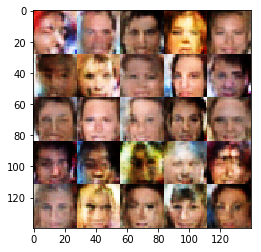

Epoch 1/1 Step 1610... Discriminator Loss: 0.6289... Generator Loss: 2.1125   difference (D-G): -1.4837
Epoch 1/1 Step 1620... Discriminator Loss: 1.0216... Generator Loss: 0.8577   difference (D-G): 0.1639
Epoch 1/1 Step 1630... Discriminator Loss: 0.7370... Generator Loss: 1.6875   difference (D-G): -0.9505
Epoch 1/1 Step 1640... Discriminator Loss: 1.0857... Generator Loss: 0.8892   difference (D-G): 0.1965
Epoch 1/1 Step 1650... Discriminator Loss: 1.3481... Generator Loss: 1.1401   difference (D-G): 0.2080
Epoch 1/1 Step 1660... Discriminator Loss: 0.9741... Generator Loss: 0.9973   difference (D-G): -0.0232
Epoch 1/1 Step 1670... Discriminator Loss: 0.8945... Generator Loss: 1.2469   difference (D-G): -0.3524
Epoch 1/1 Step 1680... Discriminator Loss: 0.9566... Generator Loss: 1.5107   difference (D-G): -0.5541
Epoch 1/1 Step 1690... Discriminator Loss: 0.9927... Generator Loss: 0.8540   difference (D-G): 0.1387
Epoch 1/1 Step 1700... Discriminator Loss: 0.7981... Generator Loss:

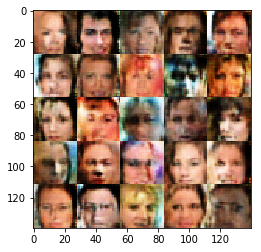

Epoch 1/1 Step 1710... Discriminator Loss: 1.3137... Generator Loss: 0.5476   difference (D-G): 0.7660
Epoch 1/1 Step 1720... Discriminator Loss: 0.7785... Generator Loss: 1.5873   difference (D-G): -0.8088
Epoch 1/1 Step 1730... Discriminator Loss: 1.4996... Generator Loss: 1.0170   difference (D-G): 0.4826
Epoch 1/1 Step 1740... Discriminator Loss: 0.7187... Generator Loss: 1.9040   difference (D-G): -1.1853
Epoch 1/1 Step 1750... Discriminator Loss: 1.2340... Generator Loss: 0.7587   difference (D-G): 0.4753
Epoch 1/1 Step 1760... Discriminator Loss: 1.4661... Generator Loss: 0.5081   difference (D-G): 0.9581
Epoch 1/1 Step 1770... Discriminator Loss: 1.1637... Generator Loss: 0.8879   difference (D-G): 0.2758
Epoch 1/1 Step 1780... Discriminator Loss: 1.1365... Generator Loss: 0.9418   difference (D-G): 0.1947
Epoch 1/1 Step 1790... Discriminator Loss: 0.7848... Generator Loss: 1.4455   difference (D-G): -0.6607
Epoch 1/1 Step 1800... Discriminator Loss: 0.8033... Generator Loss: 1

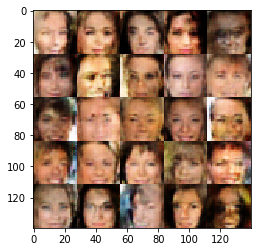

Epoch 1/1 Step 1810... Discriminator Loss: 1.1472... Generator Loss: 0.6750   difference (D-G): 0.4723
Epoch 1/1 Step 1820... Discriminator Loss: 1.0670... Generator Loss: 1.1147   difference (D-G): -0.0476
Epoch 1/1 Step 1830... Discriminator Loss: 1.2485... Generator Loss: 1.1299   difference (D-G): 0.1186
Epoch 1/1 Step 1840... Discriminator Loss: 0.8347... Generator Loss: 1.3356   difference (D-G): -0.5009
Epoch 1/1 Step 1850... Discriminator Loss: 1.5147... Generator Loss: 1.7367   difference (D-G): -0.2220
Epoch 1/1 Step 1860... Discriminator Loss: 1.5401... Generator Loss: 0.4529   difference (D-G): 1.0872
Epoch 1/1 Step 1870... Discriminator Loss: 1.0180... Generator Loss: 1.2727   difference (D-G): -0.2547
Epoch 1/1 Step 1880... Discriminator Loss: 0.7496... Generator Loss: 1.4592   difference (D-G): -0.7096
Epoch 1/1 Step 1890... Discriminator Loss: 2.0218... Generator Loss: 2.4067   difference (D-G): -0.3848
Epoch 1/1 Step 1900... Discriminator Loss: 1.3591... Generator Loss

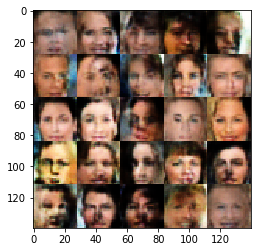

Epoch 1/1 Step 1910... Discriminator Loss: 0.6350... Generator Loss: 1.8515   difference (D-G): -1.2165
Epoch 1/1 Step 1920... Discriminator Loss: 1.0308... Generator Loss: 0.8840   difference (D-G): 0.1469
Epoch 1/1 Step 1930... Discriminator Loss: 1.4884... Generator Loss: 0.5658   difference (D-G): 0.9226
Epoch 1/1 Step 1940... Discriminator Loss: 1.0407... Generator Loss: 1.3145   difference (D-G): -0.2738
Epoch 1/1 Step 1950... Discriminator Loss: 1.0764... Generator Loss: 1.0673   difference (D-G): 0.0091
Epoch 1/1 Step 1960... Discriminator Loss: 1.4102... Generator Loss: 0.5414   difference (D-G): 0.8689
Epoch 1/1 Step 1970... Discriminator Loss: 1.1584... Generator Loss: 1.0319   difference (D-G): 0.1264
Epoch 1/1 Step 1980... Discriminator Loss: 1.2946... Generator Loss: 0.9382   difference (D-G): 0.3564
Epoch 1/1 Step 1990... Discriminator Loss: 0.7646... Generator Loss: 1.6118   difference (D-G): -0.8473
Epoch 1/1 Step 2000... Discriminator Loss: 0.7191... Generator Loss: 2

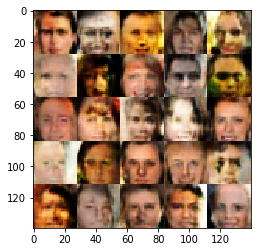

Epoch 1/1 Step 2010... Discriminator Loss: 1.2914... Generator Loss: 0.5903   difference (D-G): 0.7011
Epoch 1/1 Step 2020... Discriminator Loss: 0.8692... Generator Loss: 1.9751   difference (D-G): -1.1059
Epoch 1/1 Step 2030... Discriminator Loss: 1.0288... Generator Loss: 0.8141   difference (D-G): 0.2147
Epoch 1/1 Step 2040... Discriminator Loss: 1.7856... Generator Loss: 3.2249   difference (D-G): -1.4394
Epoch 1/1 Step 2050... Discriminator Loss: 0.9917... Generator Loss: 1.1142   difference (D-G): -0.1225
Epoch 1/1 Step 2060... Discriminator Loss: 0.9605... Generator Loss: 1.0632   difference (D-G): -0.1027
Epoch 1/1 Step 2070... Discriminator Loss: 1.4079... Generator Loss: 1.0671   difference (D-G): 0.3408
Epoch 1/1 Step 2080... Discriminator Loss: 0.9770... Generator Loss: 0.9335   difference (D-G): 0.0435
Epoch 1/1 Step 2090... Discriminator Loss: 0.7374... Generator Loss: 1.2354   difference (D-G): -0.4980
Epoch 1/1 Step 2100... Discriminator Loss: 1.1091... Generator Loss:

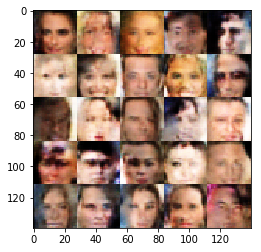

Epoch 1/1 Step 2110... Discriminator Loss: 1.1672... Generator Loss: 0.9419   difference (D-G): 0.2253
Epoch 1/1 Step 2120... Discriminator Loss: 1.4816... Generator Loss: 1.7920   difference (D-G): -0.3104
Epoch 1/1 Step 2130... Discriminator Loss: 1.4789... Generator Loss: 0.5144   difference (D-G): 0.9645
Epoch 1/1 Step 2140... Discriminator Loss: 0.9663... Generator Loss: 1.2910   difference (D-G): -0.3247
Epoch 1/1 Step 2150... Discriminator Loss: 1.5978... Generator Loss: 1.7991   difference (D-G): -0.2013
Epoch 1/1 Step 2160... Discriminator Loss: 0.7301... Generator Loss: 1.9786   difference (D-G): -1.2484
Epoch 1/1 Step 2170... Discriminator Loss: 1.1447... Generator Loss: 0.7056   difference (D-G): 0.4392
Epoch 1/1 Step 2180... Discriminator Loss: 0.7305... Generator Loss: 1.4204   difference (D-G): -0.6899
Epoch 1/1 Step 2190... Discriminator Loss: 1.3330... Generator Loss: 0.5537   difference (D-G): 0.7793
Epoch 1/1 Step 2200... Discriminator Loss: 1.3254... Generator Loss:

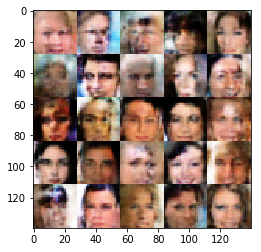

Epoch 1/1 Step 2210... Discriminator Loss: 1.1951... Generator Loss: 0.7771   difference (D-G): 0.4180
Epoch 1/1 Step 2220... Discriminator Loss: 1.2307... Generator Loss: 1.7780   difference (D-G): -0.5473
Epoch 1/1 Step 2230... Discriminator Loss: 0.9562... Generator Loss: 0.8767   difference (D-G): 0.0794
Epoch 1/1 Step 2240... Discriminator Loss: 1.3261... Generator Loss: 1.3217   difference (D-G): 0.0044
Epoch 1/1 Step 2250... Discriminator Loss: 0.9073... Generator Loss: 1.3323   difference (D-G): -0.4250
Epoch 1/1 Step 2260... Discriminator Loss: 1.0670... Generator Loss: 1.9281   difference (D-G): -0.8611
Epoch 1/1 Step 2270... Discriminator Loss: 1.2582... Generator Loss: 1.0382   difference (D-G): 0.2200
Epoch 1/1 Step 2280... Discriminator Loss: 0.8657... Generator Loss: 1.4587   difference (D-G): -0.5930
Epoch 1/1 Step 2290... Discriminator Loss: 0.9225... Generator Loss: 1.9061   difference (D-G): -0.9836
Epoch 1/1 Step 2300... Discriminator Loss: 0.5833... Generator Loss:

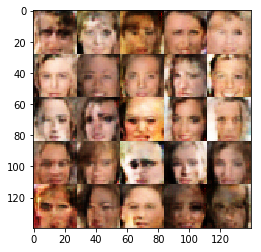

Epoch 1/1 Step 2310... Discriminator Loss: 1.2405... Generator Loss: 1.3959   difference (D-G): -0.1554
Epoch 1/1 Step 2320... Discriminator Loss: 0.7729... Generator Loss: 1.2551   difference (D-G): -0.4822
Epoch 1/1 Step 2330... Discriminator Loss: 1.2546... Generator Loss: 0.8076   difference (D-G): 0.4470
Epoch 1/1 Step 2340... Discriminator Loss: 0.9186... Generator Loss: 1.2974   difference (D-G): -0.3788
Epoch 1/1 Step 2350... Discriminator Loss: 1.0606... Generator Loss: 1.4112   difference (D-G): -0.3506
Epoch 1/1 Step 2360... Discriminator Loss: 0.7073... Generator Loss: 1.6811   difference (D-G): -0.9738
Epoch 1/1 Step 2370... Discriminator Loss: 0.5989... Generator Loss: 2.2941   difference (D-G): -1.6952
Epoch 1/1 Step 2380... Discriminator Loss: 1.1309... Generator Loss: 0.8207   difference (D-G): 0.3102
Epoch 1/1 Step 2390... Discriminator Loss: 1.4018... Generator Loss: 0.6236   difference (D-G): 0.7783
Epoch 1/1 Step 2400... Discriminator Loss: 1.1680... Generator Loss

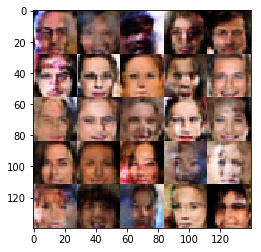

Epoch 1/1 Step 2410... Discriminator Loss: 1.0647... Generator Loss: 0.9760   difference (D-G): 0.0887
Epoch 1/1 Step 2420... Discriminator Loss: 1.4653... Generator Loss: 0.5062   difference (D-G): 0.9591
Epoch 1/1 Step 2430... Discriminator Loss: 0.8212... Generator Loss: 1.1949   difference (D-G): -0.3737
Epoch 1/1 Step 2440... Discriminator Loss: 0.8649... Generator Loss: 1.2872   difference (D-G): -0.4223
Epoch 1/1 Step 2450... Discriminator Loss: 0.8785... Generator Loss: 1.5931   difference (D-G): -0.7146
Epoch 1/1 Step 2460... Discriminator Loss: 1.4743... Generator Loss: 1.1254   difference (D-G): 0.3489
Epoch 1/1 Step 2470... Discriminator Loss: 1.0404... Generator Loss: 0.9460   difference (D-G): 0.0945
Epoch 1/1 Step 2480... Discriminator Loss: 0.8926... Generator Loss: 1.2564   difference (D-G): -0.3638
Epoch 1/1 Step 2490... Discriminator Loss: 1.6446... Generator Loss: 0.5929   difference (D-G): 1.0517
Epoch 1/1 Step 2500... Discriminator Loss: 1.0756... Generator Loss: 

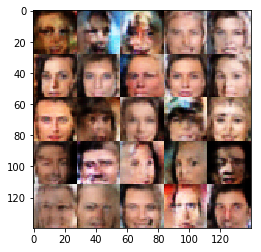

Epoch 1/1 Step 2510... Discriminator Loss: 0.7854... Generator Loss: 2.4859   difference (D-G): -1.7005
Epoch 1/1 Step 2520... Discriminator Loss: 0.8567... Generator Loss: 1.5729   difference (D-G): -0.7162
Epoch 1/1 Step 2530... Discriminator Loss: 0.7433... Generator Loss: 2.1024   difference (D-G): -1.3591
Epoch 1/1 Step 2540... Discriminator Loss: 0.6317... Generator Loss: 2.1043   difference (D-G): -1.4726
Epoch 1/1 Step 2550... Discriminator Loss: 0.7830... Generator Loss: 1.7223   difference (D-G): -0.9393
Epoch 1/1 Step 2560... Discriminator Loss: 1.2655... Generator Loss: 1.3772   difference (D-G): -0.1117
Epoch 1/1 Step 2570... Discriminator Loss: 1.1352... Generator Loss: 1.1549   difference (D-G): -0.0197
Epoch 1/1 Step 2580... Discriminator Loss: 1.2798... Generator Loss: 0.7522   difference (D-G): 0.5276
Epoch 1/1 Step 2590... Discriminator Loss: 1.2090... Generator Loss: 0.6589   difference (D-G): 0.5501
Epoch 1/1 Step 2600... Discriminator Loss: 1.0778... Generator Los

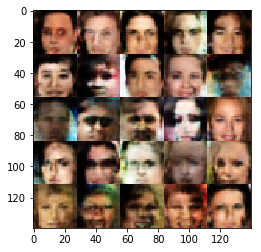

Epoch 1/1 Step 2610... Discriminator Loss: 1.6841... Generator Loss: 0.3528   difference (D-G): 1.3313
Epoch 1/1 Step 2620... Discriminator Loss: 0.6619... Generator Loss: 1.8106   difference (D-G): -1.1487
Epoch 1/1 Step 2630... Discriminator Loss: 1.5653... Generator Loss: 1.7848   difference (D-G): -0.2195
Epoch 1/1 Step 2640... Discriminator Loss: 1.0463... Generator Loss: 1.7120   difference (D-G): -0.6658
Epoch 1/1 Step 2650... Discriminator Loss: 0.8742... Generator Loss: 1.5537   difference (D-G): -0.6795
Epoch 1/1 Step 2660... Discriminator Loss: 1.1180... Generator Loss: 1.0487   difference (D-G): 0.0694
Epoch 1/1 Step 2670... Discriminator Loss: 1.0683... Generator Loss: 1.3229   difference (D-G): -0.2546
Epoch 1/1 Step 2680... Discriminator Loss: 1.1613... Generator Loss: 0.6948   difference (D-G): 0.4665
Epoch 1/1 Step 2690... Discriminator Loss: 1.3725... Generator Loss: 0.5377   difference (D-G): 0.8348
Epoch 1/1 Step 2700... Discriminator Loss: 1.2529... Generator Loss:

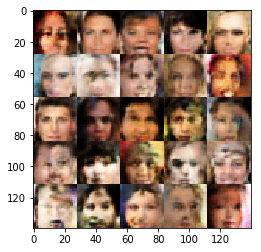

Epoch 1/1 Step 2710... Discriminator Loss: 1.4793... Generator Loss: 1.8191   difference (D-G): -0.3399
Epoch 1/1 Step 2720... Discriminator Loss: 1.0083... Generator Loss: 0.8746   difference (D-G): 0.1337
Epoch 1/1 Step 2730... Discriminator Loss: 1.0805... Generator Loss: 0.9849   difference (D-G): 0.0957
Epoch 1/1 Step 2740... Discriminator Loss: 1.1337... Generator Loss: 1.0109   difference (D-G): 0.1228
Epoch 1/1 Step 2750... Discriminator Loss: 1.2848... Generator Loss: 0.5869   difference (D-G): 0.6979
Epoch 1/1 Step 2760... Discriminator Loss: 1.3710... Generator Loss: 0.6563   difference (D-G): 0.7147
Epoch 1/1 Step 2770... Discriminator Loss: 0.4026... Generator Loss: 3.4156   difference (D-G): -3.0129
Epoch 1/1 Step 2780... Discriminator Loss: 0.4667... Generator Loss: 3.2371   difference (D-G): -2.7704
Epoch 1/1 Step 2790... Discriminator Loss: 0.3665... Generator Loss: 4.2466   difference (D-G): -3.8801
Epoch 1/1 Step 2800... Discriminator Loss: 0.4844... Generator Loss: 

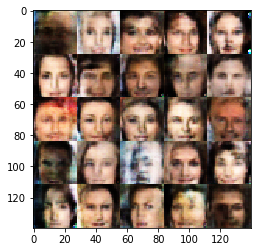

Epoch 1/1 Step 2810... Discriminator Loss: 0.5180... Generator Loss: 2.2334   difference (D-G): -1.7154
Epoch 1/1 Step 2820... Discriminator Loss: 0.8059... Generator Loss: 1.1306   difference (D-G): -0.3248
Epoch 1/1 Step 2830... Discriminator Loss: 0.8942... Generator Loss: 2.0648   difference (D-G): -1.1706
Epoch 1/1 Step 2840... Discriminator Loss: 1.2814... Generator Loss: 2.0482   difference (D-G): -0.7668
Epoch 1/1 Step 2850... Discriminator Loss: 2.1369... Generator Loss: 0.2189   difference (D-G): 1.9180
Epoch 1/1 Step 2860... Discriminator Loss: 0.7192... Generator Loss: 1.6640   difference (D-G): -0.9448
Epoch 1/1 Step 2870... Discriminator Loss: 1.0908... Generator Loss: 0.8457   difference (D-G): 0.2451
Epoch 1/1 Step 2880... Discriminator Loss: 0.6454... Generator Loss: 2.3406   difference (D-G): -1.6953
Epoch 1/1 Step 2890... Discriminator Loss: 0.8750... Generator Loss: 1.0484   difference (D-G): -0.1734
Epoch 1/1 Step 2900... Discriminator Loss: 1.3473... Generator Los

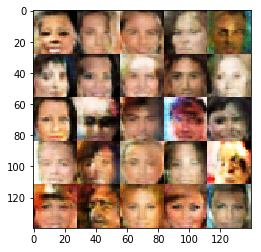

Epoch 1/1 Step 2910... Discriminator Loss: 1.2093... Generator Loss: 0.6565   difference (D-G): 0.5528
Epoch 1/1 Step 2920... Discriminator Loss: 1.1806... Generator Loss: 1.0007   difference (D-G): 0.1800
Epoch 1/1 Step 2930... Discriminator Loss: 0.6730... Generator Loss: 5.3973   difference (D-G): -4.7243
Epoch 1/1 Step 2940... Discriminator Loss: 1.0134... Generator Loss: 0.9316   difference (D-G): 0.0818
Epoch 1/1 Step 2950... Discriminator Loss: 0.9539... Generator Loss: 1.4872   difference (D-G): -0.5333
Epoch 1/1 Step 2960... Discriminator Loss: 0.8797... Generator Loss: 1.3187   difference (D-G): -0.4390
Epoch 1/1 Step 2970... Discriminator Loss: 0.9190... Generator Loss: 1.1943   difference (D-G): -0.2752
Epoch 1/1 Step 2980... Discriminator Loss: 1.0161... Generator Loss: 1.3367   difference (D-G): -0.3206
Epoch 1/1 Step 2990... Discriminator Loss: 1.0058... Generator Loss: 1.3416   difference (D-G): -0.3358
Epoch 1/1 Step 3000... Discriminator Loss: 0.8827... Generator Loss

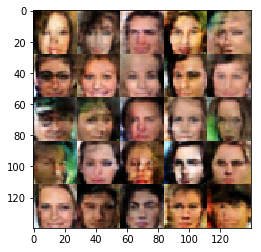

Epoch 1/1 Step 3010... Discriminator Loss: 0.9659... Generator Loss: 1.1617   difference (D-G): -0.1958
Epoch 1/1 Step 3020... Discriminator Loss: 1.4215... Generator Loss: 0.5214   difference (D-G): 0.9001
Epoch 1/1 Step 3030... Discriminator Loss: 1.2294... Generator Loss: 1.1378   difference (D-G): 0.0916
Epoch 1/1 Step 3040... Discriminator Loss: 1.4198... Generator Loss: 0.6857   difference (D-G): 0.7341
Epoch 1/1 Step 3050... Discriminator Loss: 1.1526... Generator Loss: 1.2747   difference (D-G): -0.1222
Epoch 1/1 Step 3060... Discriminator Loss: 1.3207... Generator Loss: 0.7972   difference (D-G): 0.5235
Epoch 1/1 Step 3070... Discriminator Loss: 1.3176... Generator Loss: 2.6319   difference (D-G): -1.3143
Epoch 1/1 Step 3080... Discriminator Loss: 2.0260... Generator Loss: 0.2329   difference (D-G): 1.7931
Epoch 1/1 Step 3090... Discriminator Loss: 0.9826... Generator Loss: 1.4244   difference (D-G): -0.4418
Epoch 1/1 Step 3100... Discriminator Loss: 1.6451... Generator Loss: 

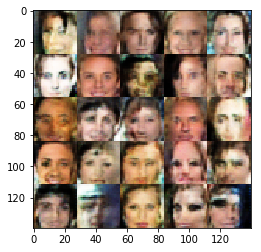

Epoch 1/1 Step 3110... Discriminator Loss: 1.2603... Generator Loss: 0.5618   difference (D-G): 0.6985
Epoch 1/1 Step 3120... Discriminator Loss: 1.1904... Generator Loss: 1.7199   difference (D-G): -0.5294
Epoch 1/1 Step 3130... Discriminator Loss: 1.3056... Generator Loss: 1.7184   difference (D-G): -0.4128
Epoch 1/1 Step 3140... Discriminator Loss: 1.2536... Generator Loss: 0.8124   difference (D-G): 0.4411
Epoch 1/1 Step 3150... Discriminator Loss: 1.3578... Generator Loss: 0.6834   difference (D-G): 0.6744
Epoch 1/1 Step 3160... Discriminator Loss: 0.7498... Generator Loss: 1.2548   difference (D-G): -0.5050


In [82]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.